In [46]:
%matplotlib qt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import h5py
import os
from scipy.stats import binned_statistic
from scipy.optimize import curve_fit
import concurrent
import pickle

import matplotlib
font = {'size'   : 16}
matplotlib.rc('font', **font)

### Get the file path

In [110]:
pole = 2
file_path = r"C:\Users\lukas\OneDrive - University of Cambridge\PhD\3DMOKE\Data\MagnetCalibration\rl_response_data_pole{}.h5".format(pole)
print(os.path.isfile(file_path))
out_folder = 'results'
try:
    os.stat(out_folder)
except:
    os.mkdir(out_folder) 
poles = [0, 1, 2]
poles_dict = {0:'A', 1:'B', 2:'C'}

True


### Get the real resistance

In [90]:
from scipy.optimize import curve_fit

plt.close('all')
fig = plt.figure(figsize=(20, 5))
R_poles = np.zeros(3)
for pole in poles:
    file_path = r"C:\Users\lukas\OneDrive - University of Cambridge\PhD\3DMOKE\Data\MagnetCalibration\rl_response_data_pole{}.h5".format(pole)
    with h5py.File(file_path, 'r') as f:
        const_keys = list(f['dc_response'].keys())
        I = np.zeros(len(const_keys))
        V = np.zeros(len(const_keys))
        for i, c in enumerate(const_keys):
            hx = f['dc_response/'+c+'/hexapole/data'][:]
            v = f['dc_response/'+c+'/v_measurement/data'][:]
            I[i] = np.mean(hx[:, pole+1])
            V[i] = -np.mean(v[:, 1])
            
    plt.subplot(1, len(poles), pole+1)
    plt.scatter(V, I, label='Data')   
    plt.xlabel('Voltage [V]')
    plt.ylabel('Current [A]')
    
    
    f = lambda x, a: a*x
    R, Rerr = curve_fit(f, I, V)
    R = R[0]
    Rerr = np.sqrt(np.diag(Rerr))[0]
    print('Resistance R:{:.4f}'.format(R))
    R_poles[pole] = R
    
    print('Error Rerr:{:}'.format(Rerr))
    x = np.linspace(0, np.max(V), 100)
    plt.plot(x, x/R, color='r', label='Ohms law fit')
    
    plt.legend()
    plt.title('Resistance {}: {:.3f} \u00B1 {:.3f} \u03A9'.format(poles_dict[pole], R, Rerr))

plt.tight_layout()
plt.savefig(os.path.join(out_folder, 'RL response pole.png'))


Resistance R:2.1185
Error Rerr:0.001202298743240538
Resistance R:2.1088
Error Rerr:0.0013526488811633503
Resistance R:2.0759
Error Rerr:0.001395405336721251


In [27]:
R_poles

array([2.11845714, 2.10878223, 2.07589811])

In [9]:


f = lambda x, a: a*x
curve_fit(f, I, V)

(array([2.07589811]), array([[1.94715605e-06]]))

### Getting the frequency response

In [117]:
def extract_max_amp(data, invert_fun=None, timestep=1/10000):
    """Extracts the frequency from the loops experiment given the instrument group.
        Returns an array frequency, max amp, phase
    """
    if invert_fun is not None:
        data = invert_fun(data)
    
    # extract fft
    n = data.shape[0]
    fft = np.fft.rfft(data, axis=0) / (n / 2)
    fft_phase = np.angle(fft)
    fft_amp = np.absolute(fft)
    freq = np.fft.rfftfreq(n, d=timestep)
    
    # get the maximum amplitude
    indx = np.unravel_index(np.argmax(fft_amp, axis=None), fft_amp.shape)
    
    return np.array([freq[indx[0]], fft_amp[indx], fft_phase[indx]])

def extract_loop_data(grp, instrument):
    data = np.vstack([grp[key][instrument]['data'][:] for key in grp.keys()])
    return data


def get_frequency_data(file_path, pole='0'):
    """Gets the fourier data from the frequency response experiment for the given pole of the magnet given the file path"""
    instruments=['v_measurement', 'hexapole']
    data = {key:[] for key in instruments}
    with h5py.File(file_path, 'r') as f:
        grp_loops = f['frequency_response/pole'+pole]
        n_loops = len(grp_loops.keys())
        for i, loops in enumerate(grp_loops.keys()):
            try:
    #             print('Loop {}/{}'.format(i, n_loops))
                for inst in instruments:
                    # get the data for the instrument
                    loop_data = extract_loop_data(grp_loops[loops], inst)
                    max_amp = extract_max_amp(loop_data[:, 1:], timestep = loop_data[1, 0]-loop_data[0, 0])
                    data[inst].append(max_amp)
            except:
                print('Data gave an error: ', loops)
    for inst in data:
        data[inst] = np.vstack(data[inst])
    
    return data

def format_freq_data(freq_data):
    """Formats the data and gets rid of the non matching data"""
    data_out = pd.DataFrame(np.hstack((freq_data['hexapole'], freq_data['v_measurement'])), 
                            columns=['i_freq', 'i_amp', 'i_phase', 'v_freq', 'v_amp', 'v_phase'])
    # make sure that all of the data matches (i.e. hallprobe and hexapole frequencies corresponse)
    freq_delta = np.abs(data_out['i_freq'] - data_out['v_freq'])
    print('There are {} data points where frequencies do not match.'.format(np.sum(freq_delta>=1/100)))
    data_out = data_out.loc[freq_delta<1/100, :]
    # drop one of the frequencies and calculate the phase delta
    data_out.drop(columns='v_freq', inplace=True)
    data_out.rename(columns={'i_freq':'freq'}, inplace=True)
    data_out['phase_delta'] = (data_out['v_phase'] - data_out['i_phase'])#%(2*np.pi)
    
    return data_out

def get_formatted_data(file_path, pole):
    data = get_frequency_data(file_path, pole=str(pole))
    return format_freq_data(data)


def get_amps(file_path, pole='0'):
    """Gets the amplitude of the data for the given pole of the magnet given the file path"""
    instruments=['v_measurement', 'hexapole']
    data = {key:[] for key in instruments}
    with h5py.File(file_path, 'r') as f:
        print(list(f['frequency_response'].keys()))
        grp_loops = f['frequency_response/pole'+pole]
        n_loops = len(grp_loops.keys())
        for i, loops in enumerate(grp_loops.keys()):
            try:
                for inst in instruments:
                    # get the data for the instrument
                    loop_data = extract_loop_data(grp_loops[loops], inst)
                    period = grp_loops['loops'].attrs['period']
                    data[inst].append(np.array([1/period, (np.max(loop_data) - np.min(loop_data))/2]))
            except:
                print('Data gave an error: ', loops)
    for inst in data:
        data[inst] = np.vstack(data[inst])
    return data


### Run the extraction by only looking at the amplitude of the data

In [119]:
amp_data = [None]*3
def get_file_path(pole):
    return r"C:\Users\lukas\OneDrive - University of Cambridge\PhD\3DMOKE\Data\MagnetCalibration\rl_response_data_pole{}.h5".format(pole)

with concurrent.futures.ThreadPoolExecutor() as executor:
    get_data_proxy = lambda p: get_amps(get_file_path(p), p)
    for pole, result in zip(poles, executor.map(get_data_proxy, poles)):
        amp_data[pole] = result

print('Done!')
# amp_data

['pole0']
['pole1']


TypeError: can only concatenate str (not "int") to str

### Run the extraction using the fft

In [77]:
# freq_data = [None]*3
# with concurrent.futures.ThreadPoolExecutor() as executor:
#     get_data_proxy = lambda p: get_formatted_data(file_path, p)
#     for pole, result in zip(poles, executor.map(get_data_proxy, poles)):
#         freq_data[pole] = result

# print('Done!')
freq_data = get_formatted_data(file_path, pole)

There are 0 data points where frequencies do not match.


### Save the result

In [78]:
# for pole in poles:
#     freq_data[pole]['phase_delta']-=2*np.pi
with open(os.path.join(out_folder,'frequency_data_pole{}.p'.format(pole)), 'wb') as fp:
    pickle.dump(freq_data, fp, protocol=4)

### Load the result if have saved

In [23]:
with open(os.path.join(out_folder,'frequency_data_pole{}.p'.format(pole)), 'rb') as fp:
    freq_data = pickle.load(fp)

### Plot the response

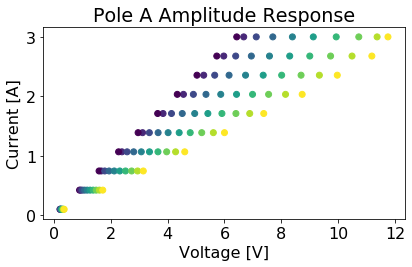

In [44]:
# for pole in poles:
plt.scatter(freq_data['v_amp'], freq_data['i_amp'], c=freq_data['freq'])
plt.xlabel('Voltage [V]')
plt.ylabel('Current [A]')
plt.title('Pole {} Amplitude Response'.format(poles_dict[pole]))
plt.tight_layout()
plt.savefig(os.path.join(out_folder, 'Amplitude_response_pole{}.png'.format(poles_dict[pole])))

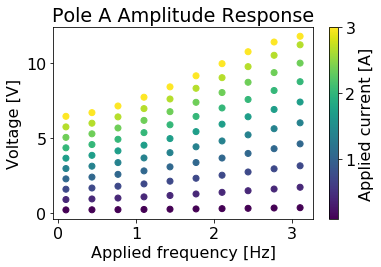

In [45]:
# for pole in poles:
plt.close()
plt.figure()
plt.scatter(freq_data['freq'], freq_data['v_amp'], c=freq_data['i_amp'])
plt.xlabel('Applied frequency [Hz]')
plt.ylabel('Voltage [V]')
plt.colorbar(label='Applied current [A]')
plt.title('Pole {} Amplitude Response'.format(poles_dict[pole]))
plt.tight_layout()
# plt.savefig(os.path.join(out_folder, 'Amplitude_response_freq_pole{}.png'.format(poles_dict[pole])))

### Plot the phases

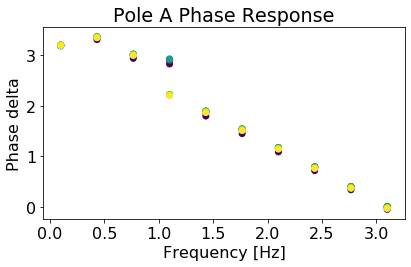

In [46]:
plt.scatter(freq_data['freq'], freq_data['phase_delta'], c=freq_data['i_amp'])#, cmap='winter')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Phase delta')
plt.title('Pole {} Phase Response'.format(poles_dict[pole]))
plt.tight_layout()
# plt.savefig(os.path.join(out_folder, 'Phase_response_pole{}.png'.format(poles_dict[pole])))

### Plot the amplitudes

In [101]:
plt.close('all')
fig = plt.figure(figsize=(20, 5))
L_poles = np.zeros(3)
for pole in poles:
    with open(os.path.join(out_folder,'frequency_data_pole{}.p'.format(pole)), 'rb') as fp:
        freq_data = pickle.load(fp)
    
    R = R_poles[pole]

    print('Pole {}'.format(poles_dict[pole]))
    V = freq_data['v_amp'].values
    f = freq_data['freq'].values
    I = freq_data['i_amp'].values

    # filter out the data where the load is too big. Here assuming a large inductance of 1H
    indx = I*np.sqrt(R**2+(np.pi*2*f)**2) < 15
    f = f[indx]
    V = V[indx]
    I = I[indx]

    x =np.hstack((f[:, np.newaxis], I[:, np.newaxis]))

    amp_fitting = lambda x, L: x[:, 1]*np.sqrt(R**2+(np.pi*2*L*x[:, 0])**2)
    popt, perr = curve_fit(amp_fitting, x, V)#, p0 = [0.01, 0.01], bounds=[[0, 0], [100, 100]])#, max_nfev=10000, diff_step=0.001)
    amp_fun = lambda x: amp_fitting(x, *popt)
    L = popt[0]
    Lerr = np.sqrt(np.diag(perr))[0]
    print('R:{}'.format(R))
    print('L:{}'.format(L))
    print('L error:{}'.format(perr[0][0]))
    L_poles[pole] = L
    
    error = amp_fun(x) - V
    rel_error = np.abs(error)/V
    print('Fit std: ', np.std(error))

    plt.subplot(1, len(poles), pole+1)
    plt.scatter(f, amp_fun(x), c='red', alpha=0.7, label='Fit, L={:.4f} H'.format(L))
    plt.scatter(f, V, c=I, marker='+', s=100, label='Data')

    plt.xlabel('Frequency [Hz]')
    plt.ylabel('Voltage amplitude [V]')
    plt.title('Pole {} Amplitude Response Fit.\nInductance: {:.3f} \u00B1 {:.3f} H'.format(poles_dict[pole], L, Lerr))
    plt.legend(loc='upper right')
plt.tight_layout()
# plt.savefig(os.path.join(out_folder, 'Amplitude_response_freq_fit.png'))
    # plt.savefig(os.path.join(out_folder, 'Small-amplitude_response_pole{}_fit.png'.format(poles_dict[pole])))

Pole A
R:2.118457140120971
L:0.20518059468941194
L error:6.452948193796469e-06
Fit std:  0.08638444893128792
Pole B
R:2.108782231622595
L:0.20839111915413808
L error:7.651103651742488e-06
Fit std:  0.09436766801027185
Pole C
R:2.07589810652447
L:0.20009208671853965
L error:7.44050197242059e-06
Fit std:  0.09188714709056058


In [106]:
err_tbl = pd.DataFrame({'error':error, 'rel_error':rel_error, 'V':V, 'I':I, 'freq':f})
err_tbl.sort_values('rel_error', ascending=False)

,error,rel_error,V,I,freq
55,0.089553,0.254406,0.352007,0.099999,3.099921
51,0.074206,0.224280,0.330862,0.100000,2.766677
47,0.060304,0.194905,0.309404,0.100000,2.433353
42,0.046407,0.160328,0.289448,0.100000,2.100007
37,0.033873,0.125387,0.270145,0.100000,1.766680
56,0.200512,0.120511,1.663854,0.422217,3.099921
52,0.156666,0.100839,1.553620,0.422222,2.766677
31,0.021403,0.084434,0.253486,0.099999,1.433315
48,0.114954,0.079496,1.446037,0.422223,2.433353
57,0.219323,0.071491,3.067849,0.744435,3.099921


In [98]:
rel_err*100

array([-0.49073668, -0.61681206, -1.01308983, -1.90488762, -2.47585912,
       -2.65161124, -2.77278755, -2.73082289, -2.67889954, -2.49481415,
       -2.31464784, -2.04808841, -0.66506762,  1.27882281, -1.46710617,
       -2.67807035, -3.25749102, -3.53877266, -3.50277549, -3.39019889,
       -3.09459807, -2.54839796, -0.68607313,  4.75374471, -0.08697183,
       -2.06764209, -3.04827919, -3.48386705, -3.55863965, -3.35042607,
       -0.7500596 ,  8.44341895,  1.54869038, -0.99220615, -2.24909253,
       -2.86838101, -0.82100274, 12.53868179,  3.46149348,  0.46407127,
       -1.20645551, -0.92058555, 16.03281354,  5.58974297,  2.07738487,
        0.42071627, -1.06296575, 19.49051003,  7.94962331,  3.52739768,
       -1.23250064, 22.42799247, 10.08391789,  5.17151158, -1.45918867,
       25.44064044, 12.05105725,  7.14907973])

In [53]:
plt.hist(error)

(array([ 6.,  8.,  7.,  9., 14.,  5.,  4.,  1.,  2.,  2.]),
 array([-0.17581891, -0.13630472, -0.09679054, -0.05727635, -0.01776217,
         0.02175201,  0.0612662 ,  0.10078038,  0.14029457,  0.17980875,
         0.21932294]),
 <a list of 10 Patch objects>)

### Adding the capacitance

In [50]:
plt.close('all')
fig = plt.figure(figsize=(20, 5))
L_poles = np.zeros(3)
for pole in poles:
    with open(os.path.join(out_folder,'frequency_data_pole{}.p'.format(pole)), 'rb') as fp:
        freq_data = pickle.load(fp)
    
    R = R_poles[pole]

    print('Pole {}'.format(poles_dict[pole]))
    V = freq_data['v_amp'].values
    f = freq_data['freq'].values
    I = freq_data['i_amp'].values

    # filter out the data where the load is too big. Here assuming a large inductance of 1H
    indx = I*np.sqrt(R**2+(np.pi*2*f)**2) < 15
    f = f[indx]
    V = V[indx]
    I = I[indx]

    x =np.hstack((f[:, np.newaxis], I[:, np.newaxis]))

    amp_fitting = lambda x, L, C: x[:, 1]*np.sqrt(R**2+(np.pi*2*L*x[:, 0] - 1/(C*np.pi*2*x[:, 0]))**2)
    popt, perr = curve_fit(amp_fitting, x, V)#, p0 = [0.01, 0.01], bounds=[[0, 0], [100, 100]])#, max_nfev=10000, diff_step=0.001)
    amp_fun = lambda x: amp_fitting(x, *popt)
    L = popt[0]
    C = popt[1]
    print('R:{}'.format(R))
    print('C:{}'.format(C))
    print('L:{}'.format(L))
#     print('L error:{}'.format(perr[0][0]))
#     L_poles[pole] = L

    plt.subplot(1, len(poles), pole+1)
    plt.scatter(f, amp_fun(x), c='red', alpha=0.7, label='Fit, L={:.4f} H'.format(L))
    plt.scatter(f, V, c=I, marker='+', s=100, label='Data')

    plt.xlabel('Frequency [Hz]')
    plt.ylabel('Voltage amplitude [V]')
    plt.title('Pole {} Amplitude Response Fit'.format(poles_dict[pole]))
    plt.legend(loc='upper right')
plt.tight_layout()
# plt.savefig(os.path.join(out_folder, 'Amplitude_response_fit_withC.png'))
    # plt.savefig(os.path.join(out_folder, 'Small-amplitude_response_pole{}_fit.png'.format(poles_dict[pole])))

Pole A
R:2.118457140120971
C:52995921.177957654
L:0.20518056100490445
Pole B
R:2.108782231622595
C:11407929.136339827
L:0.2083910812384401
Pole C
R:2.07589810652447
C:23490880.839797102
L:0.20009204193023283


In [94]:
error

array([-0.00102562, -0.00544982, -0.00219654, -0.01759671, -0.04056154,
       -0.06235599, -0.08500894, -0.10310147, -0.12012305, -0.12935172,
       -0.13617531, -0.1346249 , -0.01036566,  0.00288992, -0.01438852,
       -0.04688546, -0.0822033 , -0.11661704, -0.14215768, -0.1633079 ,
       -0.17216475, -0.16026822, -0.0153246 ,  0.01131939, -0.00091676,
       -0.03920472, -0.08365364, -0.12505068, -0.15749102, -0.17581891,
       -0.02182901,  0.02140291,  0.01770065, -0.02050797, -0.06746414,
       -0.11274608, -0.02945806,  0.03387267,  0.04294625,  0.01045456,
       -0.03960143, -0.03929075,  0.04640667,  0.07506936,  0.05088283,
        0.01500881, -0.05263259,  0.06030442,  0.11495446,  0.09377579,
       -0.06949422,  0.07420571,  0.15666578,  0.14827889, -0.09238843,
        0.08955294,  0.20051199,  0.21932294])

### Fit the phases

In [77]:
# delta_phase_functions = []
# lags = []
pole=0
# for pole in poles:
phase_delta = freq_data['phase_delta'].values
V = freq_data['v_amp'].values
f = freq_data['freq'].values
I = freq_data['i_amp'].values


# filter out the data where the load is too big. Here assuming a large inductance of 1H
indx = I*np.sqrt(R**2+(np.pi*2*f)**2) < 15
f = f[indx]
V = V[indx]
I = I[indx]
phase_delta = phase_delta[indx]
phase_delta -= np.pi
# phase_delta[f>1.1] = -np.pi/2 - phase_delta[f>1.1]
# phase_delta[phase_delta>2] -= 2*np.pi
L = L_poles[pole]
R = R_poles[pole]

delta_phase_fit = lambda x, lag: np.arctan(2*np.pi*L/R*x)+2*np.pi*lag*x
popt, perr = curve_fit(delta_phase_fit, f, phase_delta)
lag = popt[0]
print('Lag:{}'.format(lag))
# lag, A, B, C = popt[0], popt[1]#, popt[2]
# print('Lag: {}\nk:{}'.format(lag, k))
#     lags.append(lag.copy())
delta_phase_fun = lambda x, popt=popt: delta_phase_fit(x, 0)
#     delta_phase_functions.append(delta_phase_fun)

plt.close('all')
plt.scatter(f, phase_delta, c=I, cmap='winter')
plt.scatter(f, delta_phase_fun(f), c='red', alpha=0.3)#, cmap='autumn')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Phase delta')
plt.title('Pole {} Phase Response Fit'.format(poles_dict[pole]))
plt.tight_layout()
#     plt.savefig(os.path.join(out_folder, 'Phase_response_pole{}_fit.png'.format(poles_dict[pole])))

Lag:-0.1955311133374743


In [78]:
phase_delta[f>1.1]

array([-1.34826715, -1.28419527, -1.26465865, -1.25566757, -1.25143635,
       -1.69823477, -1.63157583, -1.614664  , -1.6050002 , -2.05490713,
       -1.99360224, -1.9778698 , -1.9726267 , -2.42422758, -2.37059669,
       -2.35132243, -2.80033041, -2.75486246, -2.73640373, -3.18429192,
       -3.14407569, -3.13007926])

### Save the final RL coefficients

In [45]:
# rl_coeff = [
#     {'R':2.124, 'L':0.2021},  
#     {'R':2.115, 'L':0.2047},
#     {'R':2.082, 'L':0.1966}
# ]
rl_coeff = [{'R': R, 'L': L} for R, L in zip(R_poles, L_poles)]
with open('rl_coeff.p', 'wb') as f:
    pickle.dump(rl_coeff, f)

In [44]:
rl_coeff

[{'R': 2.118457140120971, 'L': 0.20518059468941194},
 {'R': 2.108782231622595, 'L': 0.20839111915413808},
 {'R': 2.07589810652447, 'L': 0.20009208671853965}]